# Face Recognition Using Sianese Network

In [1]:
# dependencies
# !pip install opencv-python matplotlib scikit-learn pandas tensorflow gradio

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gradio as gr


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-07 16:32:31.435522: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 16:32:31.438879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 16:32:31.448350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 16:32:31.462906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 16:32:

## Splitting test and train

In [3]:
image_df = pd.read_csv('../data/dataset_image_euclidian.csv')
train_df, test_df = train_test_split(image_df, test_size=0.5, random_state=42, stratify=image_df['similarity'])

In [4]:
train_df.head()

,input1_name,input1_path,input2_name,input2_path,similarity
194,Irene_Kahn,../raw_source/Irene_Kahn/Irene_Kahn_0001.jpg,Steve_Lenard,../raw_source/Steve_Lenard/Steve_Lenard_0001.jpg,0
14,nasandratra_harivonjy,../raw_source/nasandratra_harivonjy/nasandratr...,nasandratra_harivonjy,../raw_source/nasandratra_harivonjy/nasandratr...,1
108,Anna_Jones,../raw_source/Anna_Jones/Anna_Jones_0001.jpg,Jade_Jagger,../raw_source/Jade_Jagger/Jade_Jagger_0001.jpg,0
131,Avril_Lavigne,../raw_source/Avril_Lavigne/Avril_Lavigne_0001...,Zavad_Zarif,../raw_source/Zavad_Zarif/Zavad_Zarif_0001.jpg,0
216,Jacques_Villeneuve,../raw_source/Jacques_Villeneuve/Jacques_Ville...,Zhang_Yimou,../raw_source/Zhang_Yimou/Zhang_Yimou_0001.jpg,0


### Read image

In [5]:
def preprocess_image(img, target_size):
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

In [6]:
def batch_process_images_generator(df, batch_size=128, target_size=(200, 200)):
    num_rows = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for start in range(0, num_rows, batch_size):
            end = min(start + batch_size, num_rows)
            batch_df = df.iloc[start:end]
            
            batch_images1 = []
            batch_images2 = []
            batch_similarity = []

            for index, row in batch_df.iterrows():
                
                img1 = cv2.imread(row['input1_path'])
                img2 = cv2.imread(row['input2_path'])

                if img1 is None or img2 is None:
                    continue

                img1 = preprocess_image(img1, target_size)
                img2 = preprocess_image(img2, target_size)
                    
                batch_images1.append(img1)
                batch_images2.append(img2)
                batch_similarity.append(row['similarity'])

            batch_images1 = np.array(batch_images1, dtype=np.float32)
            batch_images2 = np.array(batch_images2, dtype=np.float32)
            batch_similarity = np.array(batch_similarity)
            
            yield (batch_images1, batch_images2), batch_similarity

In [7]:
(input1, input2), similarity = next(batch_process_images_generator(train_df, batch_size=32))

0


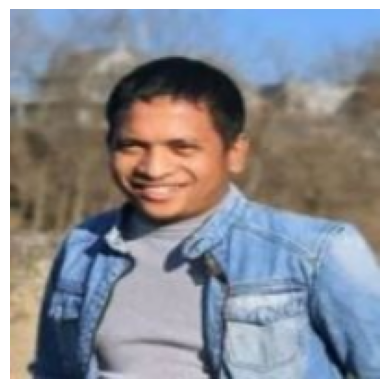

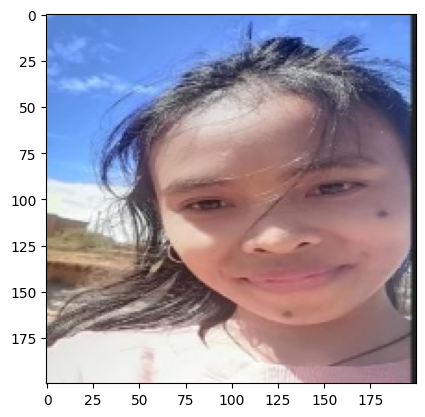

In [ ]:
print(similarity[0])
plt.imshow(input1[0])
plt.axis("off")
plt.show()
plt.imshow(input2[0])
plt.show()

### Build the Model

In [9]:
def build_siamese_model(input_shape):
    input = Input(input_shape)
    x = Conv2D(32, (10, 10), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(16, (7, 7), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='sigmoid')(x)
    return Model(input, x)
    
def build_siamese_network(input_shape):
    base_model = build_siamese_model(input_shape)

    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    
    processed_1 = base_model(input1)
    processed_2 = base_model(input2)
    
    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_1, processed_2])
    output = Dense(1, activation="sigmoid")(distance)
    model = Model([input1, input2], output)

    return model

In [10]:
input_shape = (200, 200, 3)
model = build_siamese_network(input_shape)
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

2024-10-07 16:32:34.490588: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31719424 exceeds 10% of free system memory.
2024-10-07 16:32:34.531327: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31719424 exceeds 10% of free system memory.
2024-10-07 16:32:34.543054: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31719424 exceeds 10% of free system memory.


# Train the Model

In [ ]:
train_df.shape

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback

# Define a callback to print the score at the end of each epoch and track the epoch
class EpochTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Accuracy = {logs['accuracy']}")

score_callback = EpochTracker()

batch_size = 30
epochs = 3

train_dataset = batch_process_images_generator(train_df, batch_size=batch_size)
test_dataset = batch_process_images_generator(test_df, batch_size=batch_size)

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

model.fit(train_dataset, 
          steps_per_epoch=steps_per_epoch, 
          epochs=epochs, 
          validation_data=test_dataset, 
          validation_steps=validation_steps,
          callbacks=[score_callback])


Epoch 1/3


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7', 'keras_tensor_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-10-07 16:32:35.873390: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31719424 exceeds 10% of free system memory.
2024-10-07 16:32:35.893469: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31719424 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.7667 - loss: 0.6845

In [17]:
def predict(image1, image2):
    image1 = preprocess_image(image1, target_size=(200, 200))
    image2 = preprocess_image(image2, target_size=(200, 200))

    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)

    similarity = model.predict([image1, image2])
    print(similarity)
    return "Success" if similarity[0][0] > 0.4 else "Fail"

In [18]:
interface = gr.Interface(fn=predict, 
                         inputs=[gr.Image(type="numpy"), gr.Image(type="numpy")], 
                         outputs="text")

interface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


[[[[0.24705882 0.26666667 0.35294118]
   [0.23529412 0.25882353 0.34509804]
   [0.19607843 0.21960784 0.31372549]
   ...
   [0.5372549  0.61176471 0.78039216]
   [0.5372549  0.61176471 0.78431373]
   [0.52156863 0.59607843 0.76862745]]

  [[0.35294118 0.38431373 0.48627451]
   [0.37254902 0.4        0.50196078]
   [0.33333333 0.36862745 0.4745098 ]
   ...
   [0.50196078 0.57647059 0.74509804]
   [0.50980392 0.58431373 0.75686275]
   [0.52941176 0.60392157 0.78039216]]

  [[0.60392157 0.65490196 0.78039216]
   [0.61960784 0.6745098  0.79607843]
   [0.61960784 0.67058824 0.79607843]
   ...
   [0.54509804 0.61960784 0.78823529]
   [0.54509804 0.61960784 0.79215686]
   [0.53333333 0.60784314 0.78431373]]

  ...

  [[0.40392157 0.25882353 0.17647059]
   [0.38823529 0.24705882 0.14509804]
   [0.3372549  0.21176471 0.0745098 ]
   ...
   [0.34509804 0.25490196 0.22352941]
   [0.40392157 0.31372549 0.28235294]
   [0.41960784 0.32941176 0.29803922]]

  [[0.40784314 0.24705882 0.16078431]
   [0.3